In [1]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
from matplotlib import pyplot as plt
from scipy.stats import linregress
from census import Census
import gmaps
import plotly.figure_factory as ff
import pandas as pd

# Google developer API key and census key
from config import (api_key, gkey)


# Configure gmaps and census
c = Census(api_key, year=2013)
gmaps.configure(api_key=gkey)

In [2]:
# Run Census Search to retrieve selected county data
census_data = c.acs5.get(("NAME", "COUNTY", 
                          "B01003_001E",
                          "B01002_001E",
                          "B19013_001E",
                          "B06009_003E",
                          "B23025_006E",
                          "B01001_026E",
                         ),
                         {'for': 'county:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Median Household Income",
                                      "B06009_003E": "Total High School",
                                      "B23025_006E": "Total in Armed Forces",
                                      "B01001_026E": "Total Female",
                                      "state": "state#", "NAME": "Name", 'county':'county#'})

census_pd.tail()

,Name,COUNTY,Population,Median Age,Median Household Income,Total High School,Total in Armed Forces,Total Female,state#,county#
3216,"Monroe County, West Virginia",063,13512.0,45.8,41234.0,4672.0,41.0,6819.0,54,063
3217,"Morgan County, West Virginia",065,17502.0,45.5,36046.0,6051.0,47.0,8754.0,54,065
3218,"Nicholas County, West Virginia",067,26168.0,44.1,40064.0,8895.0,56.0,13369.0,54,067
3219,"Ohio County, West Virginia",069,44156.0,43.3,41025.0,10964.0,36.0,23086.0,54,069
3220,"Pendleton County, West Virginia",071,7603.0,48.3,34175.0,2582.0,88.0,3758.0,54,071


In [4]:
#Creates separate county and state variables
census_pd[['COUNTY', 'STATE']] = ''

for index, row in census_pd.iterrows():
    nm = row['Name']
    census_pd.loc[index, ['COUNTY', 'STATE']] = nm.split(',',2)
    census_pd.loc[index, 'STATE'] = census_pd.loc[index, 'STATE'].strip()

census_pd.tail()

,Name,COUNTY,Population,Median Age,Median Household Income,Total High School,Total in Armed Forces,Total Female,state#,county#,STATE
3216,"Monroe County, West Virginia",Monroe County,13512.0,45.8,41234.0,4672.0,41.0,6819.0,54,063,West Virginia
3217,"Morgan County, West Virginia",Morgan County,17502.0,45.5,36046.0,6051.0,47.0,8754.0,54,065,West Virginia
3218,"Nicholas County, West Virginia",Nicholas County,26168.0,44.1,40064.0,8895.0,56.0,13369.0,54,067,West Virginia
3219,"Ohio County, West Virginia",Ohio County,44156.0,43.3,41025.0,10964.0,36.0,23086.0,54,069,West Virginia
3220,"Pendleton County, West Virginia",Pendleton County,7603.0,48.3,34175.0,2582.0,88.0,3758.0,54,071,West Virginia


In [6]:
#Creates 2 letter state abbreviation from full state name
us_state_abbrev = {
    'Alabama': 'al',
    'Alaska': 'ak',
    'American samoa': 'as',
    'Arizona': 'az',
    'Arkansas': 'ar',
    'California': 'ca',
    'Colorado': 'co',
    'Connecticut': 'ct',
    'Delaware': 'de',
    'District of Columbia': 'dc',
    'Florida': 'fl',
    'Georgia': 'ga',
    'Guam': 'gu',
    'Hawaii': 'hi',
    'Idaho': 'id',
    'Illinois': 'il',
    'Indiana': 'in',
    'Iowa': 'ia',
    'Kansas': 'ks',
    'Kentucky': 'ky',
    'Louisiana': 'la',
    'Maine': 'me',
    'Maryland': 'md',
    'Massachusetts': 'ma',
    'Michigan': 'mi',
    'Minnesota': 'mn',
    'Mississippi': 'ms',
    'Missouri': 'mo',
    'Montana': 'mt',
    'Nebraska': 'ne',
    'Nevada': 'nv',
    'New Hampshire': 'nh',
    'New Jersey': 'nj',
    'New Mexico': 'nm',
    'New York': 'ny',
    'North Carolina': 'nc',
    'North Dakota': 'nd',
    'Northern Mariana Islands':'mp',
    'Ohio': 'oh',
    'Oklahoma': 'ok',
    'Oregon': 'or',
    'Pennsylvania': 'pa',
    'Puerto Rico': 'pr',
    'Rhode Island': 'ri',
    'South Carolina': 'sc',
    'South Dakota': 'sd',
    'Tennessee': 'tn',
    'Texas': 'tx',
    'Utah': 'ut',
    'Vermont': 'vt',
    'Virgin Islands': 'vi',
    'Virginia': 'va',
    'Washington': 'wa',
    'West Virginia': 'wv',
    'Wisconsin': 'wi',
    'Wyoming': 'wy'
}
census_pd['state'] = ''
for index, row in census_pd.iterrows():
    stn = row['STATE']
    if stn in us_state_abbrev:
        census_pd.loc[index, 'state'] = us_state_abbrev[stn]

#creates lowercase county variable
census_pd['county'] = ''
for index, row in census_pd.iterrows():    
    upperstring1 = row['COUNTY']   
    lowerstring1 = upperstring1.lower()
    census_pd.loc[index, 'county'] = lowerstring1

#creates percent female, HS grad, and in armed forces    
census_pd['percent female']=census_pd['Total Female']/census_pd['Population']*100
census_pd['percent HS']=census_pd['Total High School']/census_pd['Population']*100
census_pd['percent AF']=census_pd['Total in Armed Forces']/census_pd['Population']*100

census_pd.tail()  

,Name,COUNTY,Population,Median Age,Median Household Income,Total High School,Total in Armed Forces,Total Female,state#,county#,STATE,state,county,percent female,percent HS,percent AF
3216,"Monroe County, West Virginia",Monroe County,13512.0,45.8,41234.0,4672.0,41.0,6819.0,54,063,West Virginia,wv,monroe county,50.466252,34.576673,0.303434
3217,"Morgan County, West Virginia",Morgan County,17502.0,45.5,36046.0,6051.0,47.0,8754.0,54,065,West Virginia,wv,morgan county,50.017141,34.573192,0.268541
3218,"Nicholas County, West Virginia",Nicholas County,26168.0,44.1,40064.0,8895.0,56.0,13369.0,54,067,West Virginia,wv,nicholas county,51.089116,33.991899,0.214002
3219,"Ohio County, West Virginia",Ohio County,44156.0,43.3,41025.0,10964.0,36.0,23086.0,54,069,West Virginia,wv,ohio county,52.282815,24.830148,0.081529
3220,"Pendleton County, West Virginia",Pendleton County,7603.0,48.3,34175.0,2582.0,88.0,3758.0,54,071,West Virginia,wv,pendleton county,49.427857,33.960279,1.157438


In [7]:
#Select subset of only needed variables
census_pd= census_pd[['state', 'county', 'Population', 'Median Age', 'Median Household Income',
                      'percent female', 'percent HS', 'percent AF']]

census_pd.tail(50)

,state,county,Population,Median Age,Median Household Income,percent female,percent HS,percent AF
3171,wa,pend oreille county,12956.0,48.3,40567.0,48.819080,24.583205,0.162087
3172,wa,pierce county,805434.0,35.8,59204.0,50.452054,18.921228,2.231592
3173,wa,san juan county,15786.0,53.3,53376.0,51.552008,13.765362,0.000000
3174,wa,skagit county,117641.0,40.4,55925.0,50.424597,17.531303,0.606931
3175,wa,skamania county,11126.0,44.9,53712.0,48.957397,19.629696,0.000000
3176,wa,snohomish county,724627.0,37.3,68381.0,49.920442,16.400438,0.554492
3177,wa,spokane county,473832.0,36.9,49233.0,50.515373,16.959809,0.476962
3178,wa,stevens county,43513.0,45.4,41742.0,49.608163,22.951762,0.101119
3179,wa,thurston county,256080.0,38.2,62229.0,51.193377,15.795845,1.623321
3180,wa,wahkiakum county,4006.0,50.3,41815.0,51.672491,26.734898,0.399401


In [20]:
#Reconciles differences in county names between datasets for merging 
fix_dic3 = {'anchorage municipality': 'anchorage borough/municipality',
            'san francisco county':'san francisco county/city',
            'broomfield county':'broomfield county/city',
            'denver county':'denver county/city',
            'honolulu county':'honolulu county/city',
            'do?a ana county': 'dona ana county',
            'philadelphia county': 'philadelphia county/city'
}
for index, row in census_pd.iterrows():
    cnty = row['county']
    if cnty in fix_dic3:
        census_pd.loc[index, 'county'] = fix_dic3[cnty]
        print(f'{cnty} changed to {fix_dic3[cnty]}')

C:\Users\Doggger\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


honolulu county changed to honolulu county/city
anchorage municipality changed to anchorage borough/municipality
san francisco county changed to san francisco county/city
broomfield county changed to broomfield county/city
denver county changed to denver county/city
do?a ana county changed to dona ana county
philadelphia county changed to philadelphia county/city


In [21]:
#Reads in UFO data
analysis_df = pd.read_csv("Data/unified2013.csv")
analysis_df.head()

,state,shape,duration (seconds),duration (hours/min),latitude,longitude,Month,Day,Time,Year,City2,county,Unemployment_rate_2013,Median_Household_Income_2018
0,fl,chevron,5.0,5 seconds,28.077778,-82.763889,10,10,02:32,2013,palm harbor,pinellas county,6.6,"52,226"
1,mo,light,10800.0,2-3 hours,38.627222,-90.197778,10,10,17:00,2013,st. louis county,st. louis county,6.2,"66,992"
2,oh,light,60.0,1 minute,40.978056,-81.782222,10,10,19:00,2013,rittman,wayne county,6.2,"59,142"
3,vt,light,120.0,2 minutes,44.490556,-73.111389,10,10,19:20,2013,essex junction,chittenden county,3.4,"74,240"
4,la,circle,600.0,10 minutes,29.993889,-90.241667,10,10,19:20,2013,kenner,jefferson parish,6.3,"50,871"


In [22]:
# Groups by state and county for merging and counting
group1_df = analysis_df.groupby(['state', 'county'])

In [23]:
#Creates new df that has count of UFO sightings per county
stacked_df = group1_df['shape'].count()
unstacked_df = stacked_df.reset_index()
unstacked_df.head(50)

,state,county,shape
0,ak,anchorage borough/municipality,12
1,ak,bethel census area,1
2,ak,fairbanks north star borough,14
3,ak,hoonah-angoon census area,1
4,ak,kenai peninsula borough,1
5,ak,ketchikan gateway borough,1
6,ak,kodiak island borough,2
7,ak,matanuska-susitna borough,10
8,ak,southeast fairbanks census area,1
9,al,autauga county,2


In [27]:
#Merges census data onto UFO counts per county dataset, renames column, and creates per capita column
merged2_df = unstacked_df.merge(census_pd, how ='left', on = ['state', 'county'])
merged2_df.rename(columns = {'shape':'UFO_sightings'}, inplace = True)
merged2_df['UFO_percapita']= merged2_df['UFO_sightings']/merged2_df['Population']
merged2_df.head()

,state,county,UFO_sightings,Population,Median Age,Median Household Income,percent female,percent HS,percent AF,UFO_percapita
0,ak,anchorage borough/municipality,12,295237.0,32.8,77454.0,49.122569,14.596409,2.961688,0.000041
1,ak,bethel census area,1,17356.0,26.2,51689.0,47.654990,21.329799,0.011523,0.000058
2,ak,fairbanks north star borough,14,98656.0,30.7,69223.0,47.022989,15.436466,5.696562,0.000142
3,ak,hoonah-angoon census area,1,2141.0,46.4,49545.0,47.174218,21.578702,0.000000,0.000467
4,ak,kenai peninsula borough,1,56163.0,40.7,61793.0,47.524171,21.583605,0.215444,0.000018


In [18]:
#used for checking county names by state
county_list2 = census_pd.loc[census_pd['state']=='nm']
county_list2['county'].unique()

array(['bernalillo county', 'catron county', 'chaves county',
       'cibola county', 'colfax county', 'curry county', 'de baca county',
       'do?a ana county', 'eddy county', 'grant county',
       'guadalupe county', 'harding county', 'hidalgo county',
       'lea county', 'lincoln county', 'los alamos county', 'luna county',
       'mckinley county', 'mora county', 'otero county', 'quay county',
       'rio arriba county', 'roosevelt county', 'sandoval county',
       'san juan county', 'san miguel county', 'santa fe county',
       'sierra county', 'socorro county', 'taos county',
       'torrance county', 'union county', 'valencia county'], dtype=object)

In [28]:
#Checks for errors in merging that lead to null values
null2_df = merged2_df.loc[(merged2_df['Population'].isnull())]
null2_df.head(50) 

,state,county,UFO_sightings,Population,Median Age,Median Household Income,percent female,percent HS,percent AF,UFO_percapita


In [29]:
#Saves dataset to file
merged2_df.to_csv(r'/Users/doggger/Desktop/AlienProject/project-1-alien-analysis/data\unified2013v2_df.csv', index = False)

In [2]:
#Reads dataset from file
merged2_df = pd.read_csv("Data/unified2013v2_df.csv")

In [30]:
#Creates correlation matrix to find relationships of interest
merged2_df = pd.read_csv("Data/unified2013v2.csv")
corr_matrix=merged2_df.corr()
corr_matrix

,UFO_sightings,Population,Median Age,Median Household Income,percent female,percent HS,percent AF,UFO_percapita
UFO_sightings,1.000000,0.798851,-0.125282,0.238131,0.125902,-0.315275,0.004773,-0.060726
Population,0.798851,1.000000,-0.188021,0.225830,0.134111,-0.315940,0.009902,-0.209795
Median Age,-0.125282,-0.188021,1.000000,-0.125305,0.000591,0.591500,-0.252466,0.341761
Median Household Income,0.238131,0.225830,-0.125305,1.000000,0.018064,-0.484137,0.085682,-0.162189
percent female,0.125902,0.134111,0.000591,0.018064,1.000000,-0.103169,-0.104444,-0.241130
percent HS,-0.315275,-0.315940,0.591500,-0.484137,-0.103169,1.000000,-0.193743,0.227342
percent AF,0.004773,0.009902,-0.252466,0.085682,-0.104444,-0.193743,1.000000,-0.084232
UFO_percapita,-0.060726,-0.209795,0.341761,-0.162189,-0.241130,0.227342,-0.084232,1.000000


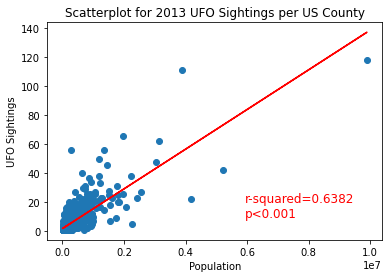

In [4]:
#Creates and saves scatterplot
x_values = merged2_df['Population']
y_values = merged2_df['UFO_sightings']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
# line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
r ='r-squared=' + str(round((rvalue*rvalue), 4))
if pvalue < 0.001:
    p = 'p<0.001'
else:
    p ='p=' + str(round(pvalue, 4))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(0,0.4),fontsize=15,color="red")
plt.annotate(r,((0.6*merged2_df['Population'].max()), 20),fontsize=12,color="red")
plt.annotate(p,((0.6*merged2_df['Population'].max()), 10), fontsize=12, color="red")
plt.xlabel('Population')
plt.ylabel('UFO Sightings')
plt.title('Scatterplot for 2013 UFO Sightings per US County')
plt.savefig('nategraphs/scatter_sightings_population.png')
plt.show()

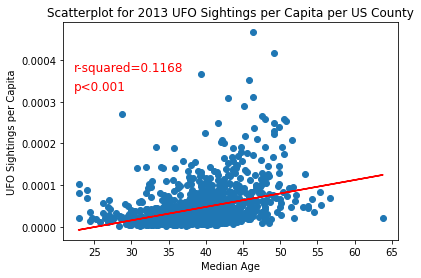

In [5]:
#Creates and saves scatterplot
x_values = merged2_df['Median Age']
y_values = merged2_df['UFO_percapita']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
# line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
r ='r-squared=' + str(round((rvalue*rvalue), 4))
if pvalue < 0.001:
    p = 'p<0.001'
else:
    p ='p=' + str(round(pvalue, 4))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(0,0.4),fontsize=15,color="red")
plt.annotate(r,((0.35*merged2_df['Median Age'].max()),(0.8*merged2_df['UFO_percapita'].max())),fontsize=12,color="red")
plt.annotate(p,((0.35*merged2_df['Median Age'].max()),(0.7*merged2_df['UFO_percapita'].max())), fontsize=12, color="red")
plt.xlabel('Median Age')
plt.ylabel('UFO Sightings per Capita')
plt.title('Scatterplot for 2013 UFO Sightings per Capita per US County')
plt.savefig('nategraphs/scatter_sightingspc_medianage.png')
plt.show()

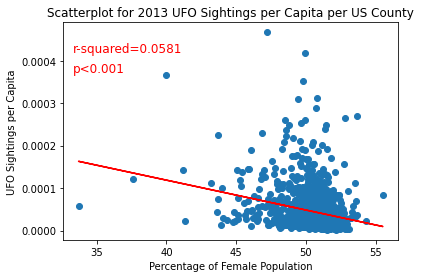

In [6]:
#Creates and saves scatterplot
x_values = merged2_df['percent female']
y_values = merged2_df['UFO_percapita']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
# line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
r ='r-squared=' + str(round((rvalue*rvalue), 4))
if pvalue < 0.001:
    p = 'p<0.001'
else:
    p ='p=' + str(round(pvalue, 4))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(0,0.4),fontsize=15,color="red")
plt.annotate(r,((0.6*merged2_df['percent female'].max()),(0.9*merged2_df['UFO_percapita'].max())),fontsize=12,color="red")
plt.annotate(p,((0.6*merged2_df['percent female'].max()),(0.8*merged2_df['UFO_percapita'].max())), fontsize=12, color="red")
plt.xlabel('Percentage of Female Population')
plt.ylabel('UFO Sightings per Capita')
plt.title('Scatterplot for 2013 UFO Sightings per Capita per US County')
plt.savefig('nategraphs/scatter_sightingspc_female.png')
plt.show()

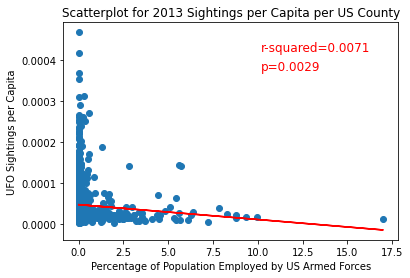

In [7]:
#Creates and saves scatterplot
x_values = merged2_df['percent AF']
y_values = merged2_df['UFO_percapita']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
# line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,5))
r ='r-squared=' + str(round((rvalue*rvalue), 4))
if pvalue < 0.001:
    p = 'p<0.001'
else:
    p ='p=' + str(round(pvalue, 4))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(0,0.4),fontsize=15,color="red")
plt.annotate(r,((0.6*merged2_df['percent AF'].max()),(0.9*merged2_df['UFO_percapita'].max())),fontsize=12,color="red")
plt.annotate(p,((0.6*merged2_df['percent AF'].max()),(0.8*merged2_df['UFO_percapita'].max())), fontsize=12, color="red")
plt.xlabel('Percentage of Population Employed by US Armed Forces')
plt.ylabel('UFO Sightings per Capita')
plt.title('Scatterplot for 2013 Sightings per Capita per US County')
plt.savefig('nategraphs/scatter_sightingspc_armedforces.png')
plt.show()

In [13]:
#creates new dataframe of top 20 counties for sightings per capita (minimum of 4 sightings) for use as a chart
morethan = merged2_df.loc[(merged2_df['UFO_sightings']>3)]
sorted_df= morethan.nlargest(20, 'UFO_percapita', keep='all')
sorted_df=sorted_df.reset_index()
sorted_df['Rank']=sorted_df.index+1
sorted_df['UFO Sightings/100,000 People']=round(sorted_df['UFO_percapita']*100000, 2)
sorted_df['Population']=sorted_df['Population'].astype(int)
sorted_df = sorted_df.rename(columns={"UFO_percapita": "UFO Sightings per Capita",
                                      "UFO_sightings": "Total UFO Sightings",
                                      "state": "State",
                                      "county": "County"})
sorted_df = sorted_df[['Rank', 'UFO Sightings/100,000 People', 'County', 'State', 'Population', 'Total UFO Sightings']]
sorted_df.to_csv(r'/Users/doggger/Desktop/AlienProject/project-1-alien-analysis/data\top20percapita.csv', index = False)
sorted_df = sorted_df.set_index('Rank')
sorted_df

,"UFO Sightings/100,000 People",County,State,Population,Total UFO Sightings
Rank,,,,,
1,30.96,kanabec county,mn,16151,5
2,26.99,fredericksburg city,va,25931,7
3,23.88,lincoln county,or,46070,11
4,20.24,horry county,sc,276688,56
5,20.19,washington county,vt,59427,12
6,18.84,clatsop county,or,37157,7
7,16.77,carroll county,nh,47694,8
8,15.59,johnson county,ar,25655,4
9,14.58,dare county,nc,34289,5


In [12]:
# Attempt to use plotly to create figure from dataframe. Was not able to add a title to figures and was abandoned
# fig =  ff.create_table(sorted_df, index=True, title='Top 20 Per Capita UFO sightings 2013 (min of 4 sightings)')
# fig.update_layout(
#     autosize=True,
# #     width=500,
# #     height=200,
# #     title='Top 20 Per Capita UFO sightings 2013 (min of 4 sightings)'
# )
# fig.write_image("table_plotly.png", scale=2)
# fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Heatmap: 'title'

    Valid properties:
        autocolorscale
            Determines whether the colorscale is a default palette
            (`autocolorscale: true`) or the palette determined by
            `colorscale`. In case `colorscale` is unspecified or
            `autocolorscale` is true, the default  palette will be
            chosen according to whether numbers in the `color`
            array are all positive, all negative or mixed.
        coloraxis
            Sets a reference to a shared color axis. References to
            these shared color axes are "coloraxis", "coloraxis2",
            "coloraxis3", etc. Settings for these shared color axes
            are set in the layout, under `layout.coloraxis`,
            `layout.coloraxis2`, etc. Note that multiple color
            scales can be linked to the same color axis.
        colorbar
            :class:`plotly.graph_objects.heatmap.ColorBar` instance
            or dict with compatible properties
        colorscale
            Sets the colorscale. The colorscale must be an array
            containing arrays mapping a normalized value to an rgb,
            rgba, hex, hsl, hsv, or named color string. At minimum,
            a mapping for the lowest (0) and highest (1) values are
            required. For example, `[[0, 'rgb(0,0,255)'], [1,
            'rgb(255,0,0)']]`. To control the bounds of the
            colorscale in color space, use`zmin` and `zmax`.
            Alternatively, `colorscale` may be a palette name
            string of the following list: Greys,YlGnBu,Greens,YlOrR
            d,Bluered,RdBu,Reds,Blues,Picnic,Rainbow,Portland,Jet,H
            ot,Blackbody,Earth,Electric,Viridis,Cividis.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the `z` data are filled in. It is defaulted
            to true if `z` is a one dimensional array and `zsmooth`
            is not false; otherwise it is defaulted to false.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            customdata .
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            hoverinfo .
        hoverlabel
            :class:`plotly.graph_objects.heatmap.Hoverlabel`
            instance or dict with compatible properties
        hoverongaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the `z` data have hover labels associated
            with them.
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-time-format#locale_format for
            details on the date formatting syntax. The variables
            available in `hovertemplate` are the ones emitted as
            event data described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            hovertemplate .
        hovertext
            Same as `text`.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        reversescale
            Reverses the color mapping if true. If true, `zmin`
            will correspond to the last color in the array and
            `zmax` will correspond to the first color.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        showscale
            Determines whether or not a colorbar is displayed for
            this trace.
        stream
            :class:`plotly.graph_objects.heatmap.Stream` instance
            or dict with compatible properties
        text
            Sets the text elements associated with each z value.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            text .
        transpose
            Transposes the z data.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xgap
            Sets the horizontal gap (in pixels) between bricks.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for  x
            .
        xtype
            If "array", the heatmap's x coordinates are given by
            "x" (the default behavior when `x` is provided). If
            "scaled", the heatmap's x coordinates are given by "x0"
            and "dx" (the default behavior when `x` is not
            provided).
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        ygap
            Sets the vertical gap (in pixels) between bricks.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for  y
            .
        ytype
            If "array", the heatmap's y coordinates are given by
            "y" (the default behavior when `y` is provided) If
            "scaled", the heatmap's y coordinates are given by "y0"
            and "dy" (the default behavior when `y` is not
            provided)
        z
            Sets the z data.
        zauto
            Determines whether or not the color domain is computed
            with respect to the input data (here in `z`) or the
            bounds set in `zmin` and `zmax`  Defaults to `false`
            when `zmin` and `zmax` are set by the user.
        zhoverformat
            Sets the hover text formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. See: https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format
        zmax
            Sets the upper bound of the color domain. Value should
            have the same units as in `z` and if set, `zmin` must
            be set as well.
        zmid
            Sets the mid-point of the color domain by scaling
            `zmin` and/or `zmax` to be equidistant to this point.
            Value should have the same units as in `z`. Has no
            effect when `zauto` is `false`.
        zmin
            Sets the lower bound of the color domain. Value should
            have the same units as in `z` and if set, `zmax` must
            be set as well.
        zsmooth
            Picks a smoothing algorithm use to smooth `z` data.
        zsrc
            Sets the source reference on Chart Studio Cloud for  z
            .
        

In [14]:
#creates new dataframe of top 20 counties for sightings total for use as a chart
sorted2_df= merged2_df.nlargest(20, 'UFO_sightings', keep='all')
sorted2_df=sorted2_df.reset_index()
sorted2_df['Rank']=sorted2_df.index+1
sorted2_df['UFO Sightings/100,000 People']=round(sorted2_df['UFO_percapita']*100000, 2)
sorted2_df['Population']=sorted2_df['Population'].astype(int)
sorted2_df = sorted2_df.rename(columns={"UFO_percapita": "UFO Sightings per Capita",
                                       "UFO_sightings": "Total UFO Sightings",
                                       "state": "State",
                                       "county": "County"})
sorted2_df = sorted2_df[['Rank', 'Total UFO Sightings','County', 'State', 'Population', 'UFO Sightings/100,000 People']]
sorted2_df.to_csv(r'/Users/doggger/Desktop/AlienProject/project-1-alien-analysis/data\top20.csv', index = False)
sorted2_df = sorted2_df.set_index('Rank')
sorted2_df

,Total UFO Sightings,County,State,Population,"UFO Sightings/100,000 People"
Rank,,,,,
1,118,los angeles county,ca,9893481,1.19
2,111,maricopa county,az,3889161,2.85
3,66,king county,wa,1974567,3.34
4,62,san diego county,ca,3138265,1.98
5,56,palm beach county,fl,1339221,4.18
6,56,horry county,sc,276688,20.24
7,50,franklin county,oh,1181824,4.23
8,48,orange county,ca,3051771,1.57
9,46,sacramento county,ca,1435207,3.21
